<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/improvement_Lucia2/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b improvement_Lucia2 https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2263 (delta 10), reused 0 (delta 0), pack-reused 2242
Receiving objects: 100% (2263/2263), 2.83 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
exemplars = [None]*100

test_indexes =  []
accs = []

At step  0  and at epoch =  0  the loss is =  0.03219613805413246  and accuracy is =  0.1542
At step  0  and at epoch =  1  the loss is =  0.024425501003861427  and accuracy is =  0.374
At step  0  and at epoch =  2  the loss is =  0.026289481669664383  and accuracy is =  0.4458
At step  0  and at epoch =  3  the loss is =  0.03029630146920681  and accuracy is =  0.523
At step  0  and at epoch =  4  the loss is =  0.01861530914902687  and accuracy is =  0.5684
At step  0  and at epoch =  5  the loss is =  0.0300718042999506  and accuracy is =  0.6072
At step  0  and at epoch =  6  the loss is =  0.01973263919353485  and accuracy is =  0.6406
At step  0  and at epoch =  7  the loss is =  0.02217886410653591  and accuracy is =  0.6618
At step  0  and at epoch =  8  the loss is =  0.013632857240736485  and accuracy is =  0.6748
At step  0  and at epoch =  9  the loss is =  0.008944962173700333  and accuracy is =  0.718
At step  0  and at epoch =  10  the loss is =  0.013350958935916424  a

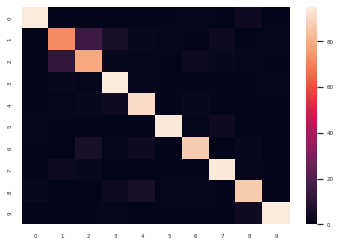

At step  10  and at epoch =  0  the loss is =  0.029528988525271416  and accuracy is =  0.297
At step  10  and at epoch =  1  the loss is =  0.02645486406981945  and accuracy is =  0.37842857142857145
At step  10  and at epoch =  2  the loss is =  0.027002809569239616  and accuracy is =  0.46414285714285713
At step  10  and at epoch =  3  the loss is =  0.021550079807639122  and accuracy is =  0.528
At step  10  and at epoch =  4  the loss is =  0.02378280647099018  and accuracy is =  0.5618571428571428
At step  10  and at epoch =  5  the loss is =  0.02465241216123104  and accuracy is =  0.5967142857142858
At step  10  and at epoch =  6  the loss is =  0.02146647498011589  and accuracy is =  0.6285714285714286
At step  10  and at epoch =  7  the loss is =  0.022409701719880104  and accuracy is =  0.6482857142857142
At step  10  and at epoch =  8  the loss is =  0.020572859793901443  and accuracy is =  0.664
At step  10  and at epoch =  9  the loss is =  0.0210245493799448  and accurac

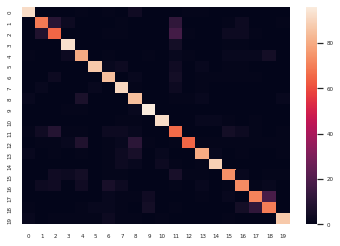

At step  20  and at epoch =  0  the loss is =  0.03585805371403694  and accuracy is =  0.354
At step  20  and at epoch =  1  the loss is =  0.03342461213469505  and accuracy is =  0.410375
At step  20  and at epoch =  2  the loss is =  0.03256015479564667  and accuracy is =  0.47875
At step  20  and at epoch =  3  the loss is =  0.02992243878543377  and accuracy is =  0.546125
At step  20  and at epoch =  4  the loss is =  0.028710879385471344  and accuracy is =  0.576125
At step  20  and at epoch =  5  the loss is =  0.02730417624115944  and accuracy is =  0.609625
At step  20  and at epoch =  6  the loss is =  0.026081403717398643  and accuracy is =  0.625
At step  20  and at epoch =  7  the loss is =  0.027049293741583824  and accuracy is =  0.649375
At step  20  and at epoch =  8  the loss is =  0.030109919607639313  and accuracy is =  0.665875
At step  20  and at epoch =  9  the loss is =  0.030148806050419807  and accuracy is =  0.67525
At step  20  and at epoch =  10  the loss i

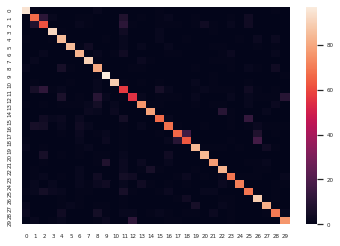

At step  30  and at epoch =  0  the loss is =  0.03937281668186188  and accuracy is =  0.3931949250288351
At step  30  and at epoch =  1  the loss is =  0.03487863764166832  and accuracy is =  0.44878892733564013
At step  30  and at epoch =  2  the loss is =  0.037432678043842316  and accuracy is =  0.5124567474048443
At step  30  and at epoch =  3  the loss is =  0.038555268198251724  and accuracy is =  0.5657439446366782
At step  30  and at epoch =  4  the loss is =  0.03543270751833916  and accuracy is =  0.5931949250288351
At step  30  and at epoch =  5  the loss is =  0.034201983362436295  and accuracy is =  0.6222606689734718
At step  30  and at epoch =  6  the loss is =  0.032511964440345764  and accuracy is =  0.6401384083044983
At step  30  and at epoch =  7  the loss is =  0.031207256019115448  and accuracy is =  0.6516724336793541
At step  30  and at epoch =  8  the loss is =  0.033364810049533844  and accuracy is =  0.6599769319492503
At step  30  and at epoch =  9  the los

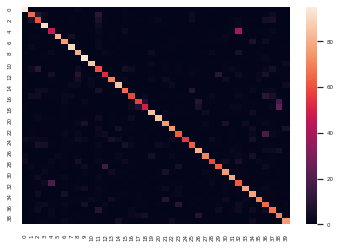

At step  40  and at epoch =  0  the loss is =  0.046639468520879745  and accuracy is =  0.4044711014176663
At step  40  and at epoch =  1  the loss is =  0.04787081852555275  and accuracy is =  0.4559432933478735
At step  40  and at epoch =  2  the loss is =  0.04496025666594505  and accuracy is =  0.49236641221374045
At step  40  and at epoch =  3  the loss is =  0.04689378663897514  and accuracy is =  0.5300981461286804
At step  40  and at epoch =  4  the loss is =  0.042268335819244385  and accuracy is =  0.5488549618320611
At step  40  and at epoch =  5  the loss is =  0.044052984565496445  and accuracy is =  0.566412213740458
At step  40  and at epoch =  6  the loss is =  0.04359706863760948  and accuracy is =  0.5849509269356598
At step  40  and at epoch =  7  the loss is =  0.03936767578125  and accuracy is =  0.5993456924754634
At step  40  and at epoch =  8  the loss is =  0.0427296943962574  and accuracy is =  0.6177753544165758
At step  40  and at epoch =  9  the loss is =  

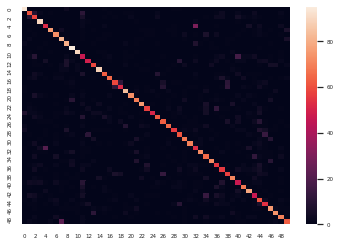

At step  50  and at epoch =  0  the loss is =  0.05612964928150177  and accuracy is =  0.4088819226750261
At step  50  and at epoch =  1  the loss is =  0.052739184349775314  and accuracy is =  0.4689655172413793
At step  50  and at epoch =  2  the loss is =  0.05595478415489197  and accuracy is =  0.515778474399164
At step  50  and at epoch =  3  the loss is =  0.045178528875112534  and accuracy is =  0.5396029258098224
At step  50  and at epoch =  4  the loss is =  0.04964965581893921  and accuracy is =  0.5619644723092999
At step  50  and at epoch =  5  the loss is =  0.045273687690496445  and accuracy is =  0.5770114942528736
At step  50  and at epoch =  6  the loss is =  0.04818975552916527  and accuracy is =  0.587042842215256
At step  50  and at epoch =  7  the loss is =  0.050851009786129  and accuracy is =  0.6071055381400209
At step  50  and at epoch =  8  the loss is =  0.05042227357625961  and accuracy is =  0.6136886102403344
At step  50  and at epoch =  9  the loss is =  

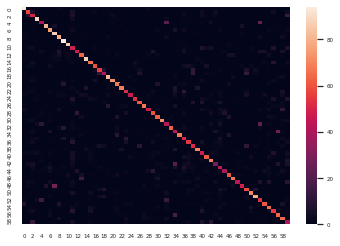

At step  60  and at epoch =  0  the loss is =  0.056634481996297836  and accuracy is =  0.415959595959596
At step  60  and at epoch =  1  the loss is =  0.06521689891815186  and accuracy is =  0.45595959595959595
At step  60  and at epoch =  2  the loss is =  0.05011214315891266  and accuracy is =  0.48494949494949496
At step  60  and at epoch =  3  the loss is =  0.051445528864860535  and accuracy is =  0.5143434343434343
At step  60  and at epoch =  4  the loss is =  0.05092301964759827  and accuracy is =  0.535050505050505
At step  60  and at epoch =  5  the loss is =  0.062151968479156494  and accuracy is =  0.5430303030303031
At step  60  and at epoch =  6  the loss is =  0.053095798939466476  and accuracy is =  0.5631313131313131
At step  60  and at epoch =  7  the loss is =  0.05884891748428345  and accuracy is =  0.5703030303030303
At step  60  and at epoch =  8  the loss is =  0.0583098866045475  and accuracy is =  0.5838383838383838
At step  60  and at epoch =  9  the loss is

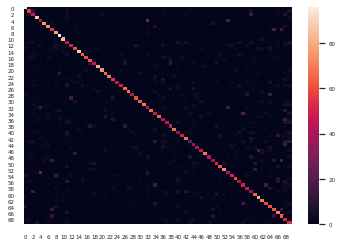

At step  70  and at epoch =  0  the loss is =  0.05978542938828468  and accuracy is =  0.4088321884200196
At step  70  and at epoch =  1  the loss is =  0.06885889917612076  and accuracy is =  0.49646712463199216
At step  70  and at epoch =  2  the loss is =  0.06614070385694504  and accuracy is =  0.5406280667320903
At step  70  and at epoch =  3  the loss is =  0.06487462669610977  and accuracy is =  0.5773307163886163
At step  70  and at epoch =  4  the loss is =  0.061123307794332504  and accuracy is =  0.5975466143277723
At step  70  and at epoch =  5  the loss is =  0.05642439424991608  and accuracy is =  0.6115799803729146
At step  70  and at epoch =  6  the loss is =  0.06310288608074188  and accuracy is =  0.6342492639842984
At step  70  and at epoch =  7  the loss is =  0.05560189113020897  and accuracy is =  0.6404317958783121
At step  70  and at epoch =  8  the loss is =  0.05899195000529289  and accuracy is =  0.6466143277723259
At step  70  and at epoch =  9  the loss is 

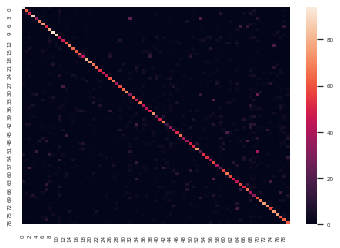

At step  80  and at epoch =  0  the loss is =  0.07345347106456757  and accuracy is =  0.4165708812260536
At step  80  and at epoch =  1  the loss is =  0.07345559448003769  and accuracy is =  0.4814176245210728
At step  80  and at epoch =  2  the loss is =  0.07786306738853455  and accuracy is =  0.5171455938697318
At step  80  and at epoch =  3  the loss is =  0.07260922342538834  and accuracy is =  0.5434865900383141
At step  80  and at epoch =  4  the loss is =  0.0720619410276413  and accuracy is =  0.5620689655172414
At step  80  and at epoch =  5  the loss is =  0.07376109063625336  and accuracy is =  0.5798850574712644
At step  80  and at epoch =  6  the loss is =  0.07720989733934402  and accuracy is =  0.5915708812260536
At step  80  and at epoch =  7  the loss is =  0.06754349172115326  and accuracy is =  0.596360153256705
At step  80  and at epoch =  8  the loss is =  0.07603361457586288  and accuracy is =  0.6099616858237548
At step  80  and at epoch =  9  the loss is =  0

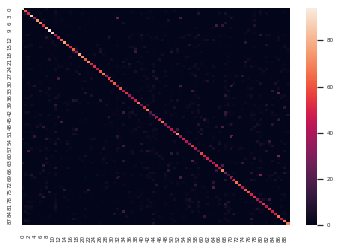

At step  90  and at epoch =  0  the loss is =  0.07890269160270691  and accuracy is =  0.42457786116322704
At step  90  and at epoch =  1  the loss is =  0.08678707480430603  and accuracy is =  0.5040337711069418
At step  90  and at epoch =  2  the loss is =  0.07180420309305191  and accuracy is =  0.5285178236397748
At step  90  and at epoch =  3  the loss is =  0.07477344572544098  and accuracy is =  0.5531894934333959
At step  90  and at epoch =  4  the loss is =  0.07369875907897949  and accuracy is =  0.5697936210131332
At step  90  and at epoch =  5  the loss is =  0.06774802505970001  and accuracy is =  0.5867729831144465
At step  90  and at epoch =  6  the loss is =  0.07269026339054108  and accuracy is =  0.5916510318949343
At step  90  and at epoch =  7  the loss is =  0.0750788226723671  and accuracy is =  0.6045028142589118
At step  90  and at epoch =  8  the loss is =  0.0848400741815567  and accuracy is =  0.6183864915572233
At step  90  and at epoch =  9  the loss is =  

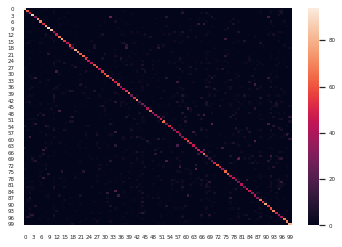

In [10]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
      tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()

In [11]:
accs = [.90,.80,.76,.69,.64,.58,.54,.52,.48,.46]

In [12]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plotTask(pars_tasks):

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy'])
  plt.xlabel("Epoch")
  plt.ylim(0,1)
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy'])
  plt.grid(True)
  plt.show()

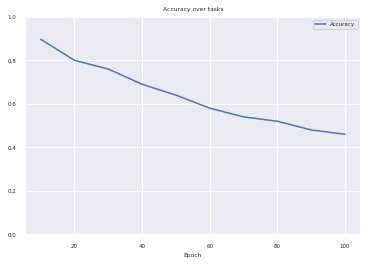

In [13]:
plotTask(accs)

In [14]:
np.diagonal(cf)

array([94, 62, 49, 88, 31, 73, 70, 52, 74, 91, 84, 37, 47, 66, 78, 55, 44,
       58, 41, 80, 70, 62, 64, 53, 45, 44, 59, 62, 42, 55, 59, 66, 27, 60,
       46, 59, 35, 42, 53, 67, 24, 51, 74, 15, 27, 26, 40, 65, 34, 37, 31,
       48, 64, 25, 50, 45, 32, 43, 32, 28, 50, 60, 48, 45, 38, 48, 41, 67,
       27, 12, 24, 48, 61, 50, 37, 64, 64, 43, 46, 29, 24, 43, 25, 49, 45,
       33, 46, 31, 67, 53, 78, 55, 60, 71, 49, 35, 40, 69, 70, 81])

In [15]:
true = np.sum(cf, axis=1)
true

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100])

In [16]:
pred = np.sum(cf, axis=0)
pred

array([129, 110, 157, 144,  80,  86, 126, 109, 137, 146, 101, 149,  85,
       118,  99,  95,  67,  99,  87, 110,  83, 108,  82,  89,  60,  65,
        86,  98,  85,  83,  98, 101, 108,  79, 143,  82,  82,  92, 114,
        89,  81,  75, 133,  73, 142,  70,  67,  92,  65,  65,  88,  78,
       101,  83,  83,  84,  62, 109, 105, 132,  91, 118,  99,  77, 103,
        87, 101, 122, 137,  92,  80,  94,  76,  64,  70, 121,  84, 125,
       111,  87, 124,  65,  63,  91, 107,  58, 126,  71, 157,  77,  96,
       149, 189, 116, 115, 138, 126, 110, 113, 121])

In [17]:
pred = np.array([137,  98, 142, 112,  39,  82, 116,  96, 145, 112,  84, 110,  59,
        96,  73,  78,  50,  91,  98,  92,  64, 109,  91,  72,  38,  70,
        76,  81,  89, 102,  81, 116,  72,  59, 177,  59,  62,  63,  93,
        90,  72,  79, 102,  52, 162,  68,  67,  80,  65,  98,  80,  65,
        84,  96, 121,  53,  77, 136,  69, 103,  76,  94, 109,  79, 126,
        61, 126, 106, 182,  68, 122,  94,  90,  80,  80, 159,  98, 132,
       145,  88, 170,  77,  79,  78, 131,  74, 149,  70, 149, 114, 102,
       172, 212, 134, 124, 187, 189, 114, 126, 131])

In [18]:
i = 0
for el, name in zip(pred,trainDS.__getClassesNames__()) :
  print('classe', i, 'name', name, ',preds', el)
  i+=1

classe 0 name apple ,preds 137
classe 1 name aquarium_fish ,preds 98
classe 2 name baby ,preds 142
classe 3 name bear ,preds 112
classe 4 name beaver ,preds 39
classe 5 name bed ,preds 82
classe 6 name bee ,preds 116
classe 7 name beetle ,preds 96
classe 8 name bicycle ,preds 145
classe 9 name bottle ,preds 112
classe 10 name bowl ,preds 84
classe 11 name boy ,preds 110
classe 12 name bridge ,preds 59
classe 13 name bus ,preds 96
classe 14 name butterfly ,preds 73
classe 15 name camel ,preds 78
classe 16 name can ,preds 50
classe 17 name castle ,preds 91
classe 18 name caterpillar ,preds 98
classe 19 name cattle ,preds 92
classe 20 name chair ,preds 64
classe 21 name chimpanzee ,preds 109
classe 22 name clock ,preds 91
classe 23 name cloud ,preds 72
classe 24 name cockroach ,preds 38
classe 25 name couch ,preds 70
classe 26 name crab ,preds 76
classe 27 name crocodile ,preds 81
classe 28 name cup ,preds 89
classe 29 name dinosaur ,preds 102
classe 30 name dolphin ,preds 81
classe 31 na

In [19]:
train_splits

[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0],
 [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0],
 [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0],
 [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0],
 [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0],
 [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0],
 [57.0, 81.0, 12.0, 95.0, 25.0, 47.0, 34.0, 52.0, 44.0, 72.0],
 [46.0, 79.0, 20.0, 28.0, 5.0, 71.0, 8.0, 18.0, 33.0, 15.0],
 [55.0, 29.0, 64.0, 31.0, 67.0, 7.0, 13.0, 14.0, 42.0, 6.0],
 [82.0, 2.0, 27.0, 16.0, 26.0, 3.0, 4.0, 1.0, 9.0, 0.0]]

In [20]:
trainDS.__getClassesNames__()

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig